In [22]:
import json
import pandas as pd
import plotly.express as px
import numpy as np
from wordcloud import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [23]:
with open('../data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

# Mots par document (sans ponctuation, sans stop-words)

In [24]:
nbDocs = len(docs)
tailleDocs = [len(doc) for doc in docs]
nbMots = sum(tailleDocs)

print(f"Nombre de documents : {nbDocs} | Nombre de mots : {nbMots}")

Nombre de documents : 9501 | Nombre de mots : 71333


In [25]:
for doc in docs:
    doc = [mot for mot in doc if mot not in ['~%', 'cl', 'kt']]

In [26]:
tailleDocs = pd.DataFrame(tailleDocs, columns = ["Lemme"])

fig = px.histogram(tailleDocs, x = "Lemme", title = "Histogramme du nombre de mots par documents")
fig.show()

In [59]:
temp = pd.DataFrame(columns = ['Nombre de lemmes', 'Nombre de documents'])
temp['Nombre de lemmes'] = list(set(tailleDocs.Lemme))
temp['Nombre de documents'] = 0
for t in tailleDocs.Lemme:
    temp.loc[temp['Nombre de lemmes'] == t,'Nombre de documents'] += 1

In [67]:
fig = px.bar(temp, x = "Nombre de lemmes", y = 'Nombre de documents', title = "Nombre de mots par documents")
mean = np.mean(tailleDocs.Lemme)
fig.add_shape(type="line",x0=mean, x1=mean, y0 =0, y1=1300 , xref='x', yref='y',
               line = dict(color = 'red', dash = 'dash'))

# Importance des lemmes

## Présence globale (fréquence d'apparition sur le corpus)

In [27]:
freqMots = {}
ensembleMots = set()
for doc in docs:
    for mot in doc:
        if mot not in freqMots:
            ensembleMots.add(mot)
            freqMots[mot] = 1
        else:
            freqMots[mot] += 1

Enregistrement des lemmes (uniques) dans un fichier texte

In [28]:
file = open("../data/liste_lemmes.txt", 'w')
for lemme in freqMots.keys():
    file.writelines(lemme + '\n')
file.close()

Ordonnancement décroissant, transformation en _dataframe_

In [29]:
freqMots = sorted(freqMots.items(), key = lambda m: m[1], reverse = True)
freqMots = pd.DataFrame(freqMots, columns = ['Lemme', 'Occurrences'])
freqMots['Fréquence'] = freqMots['Occurrences'] * 100 / nbMots

### Lemmes les plus utilisés (représentatifs du sujet)

In [30]:
nbLemmesAfficher = 10
fig = px.bar(freqMots.iloc[:nbLemmesAfficher,:], x = 'Lemme', y = 'Fréquence',
title = "Fréquence (%) d'apparition des lemmes dans les propositions")
fig.update_layout(font_size = 18)
fig.show()

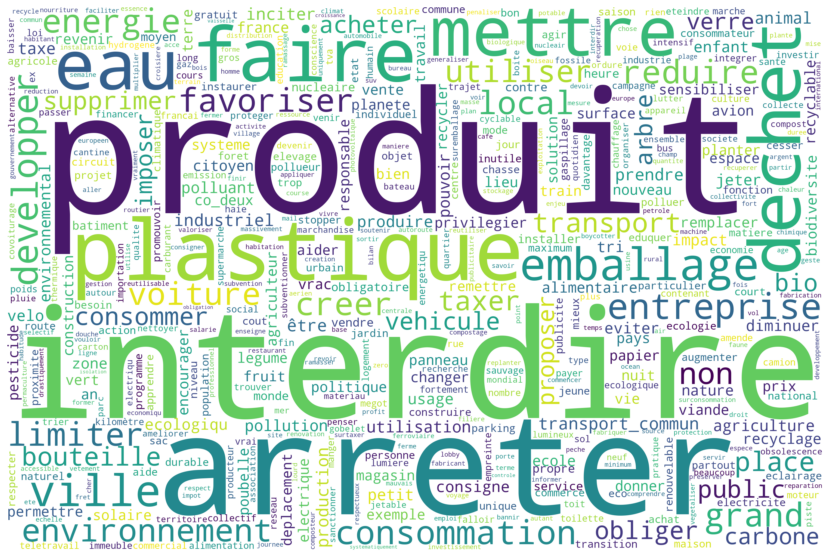

In [31]:
#Word Cloud
dict_wordcloud = freqMots.copy()
dict_wordcloud = dict_wordcloud.set_index("Lemme")
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500)
wordcloud.generate_from_frequencies(frequencies=dict_wordcloud.to_dict()["Fréquence"])
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Lemmes les moins utilisés (les plus discriminants)

In [32]:
freqMin = 100 / nbMots
motsUniques = [freqMots.loc[i,"Lemme"] for i in range(len(freqMots)) if freqMots.loc[i,"Fréquence"] == freqMin]
del freqMin

In [33]:
print(f"Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : {len(motsUniques)} ; {100 * len(motsUniques) / len(freqMots)} %.")

Nombre ; Proportion de mots n'ayant été utilisés qu'une seule fois sur l'ensemble des documents : 3266 ; 45.16664361775688 %.


## Termes discriminants (IDF, nombre de documents possédant chaque mot)

In [34]:
idf = {}
df = {}
for mot in ensembleMots:
    nbDocsMotPresent = 0
    for doc in docs:
        if mot in doc:
            nbDocsMotPresent += 1
    df[mot] = nbDocsMotPresent
    idf[mot] = - np.log(df[mot] / len(docs))

Ordonnancement décroissant, transformation en _dataframe_

In [35]:
idf = sorted(idf.items(), key = lambda m: m[1], reverse = True)
idf = pd.DataFrame(idf, columns = ['Lemme', 'IDF'])
df = sorted(df.items(), key = lambda m: m[1], reverse = True)
df = pd.DataFrame(df, columns = ['Lemme', 'DF (absolu)'])
df['DF'] = df['DF (absolu)'] / len(docs)
df["Nombre moyen par document"] = 0
for v in df.Lemme:
    df.loc[df['Lemme'] == v, "Nombre moyen par document"] = freqMots.loc[freqMots['Lemme'] == v, "Occurrences"].values / (df.loc[df['Lemme'] == v,'DF'].values * len(docs))

In [36]:
#nbLemmesAfficher = 20
fig = px.bar(idf.loc[:,:], x = 'Lemme', y = 'IDF',
title = "IDF des différents lemmes")
fig.show()

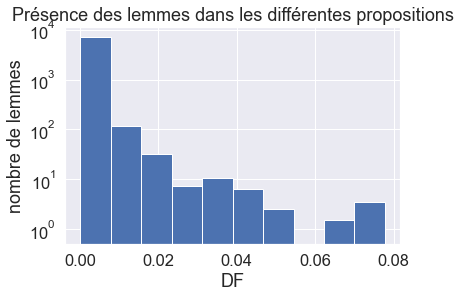

In [37]:
plt.hist(df.DF, log = True, bottom = .5)
plt.xlabel("DF")
plt.ylabel("nombre de lemmes")
_ = plt.title("Présence des lemmes dans les différentes propositions")

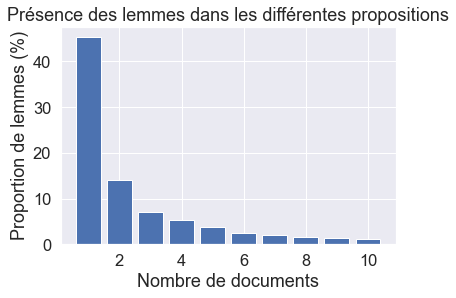

In [38]:
nbDocsLemmes = list(df.DF * len(docs))
nbDocsLemmes = np.array([int(v) for v in nbDocsLemmes])
valeurs = list(set(nbDocsLemmes))
valeurs = [v for v in valeurs if v <= 10]
valeurs.sort()
quantite = [100 * np.sum(nbDocsLemmes == v) / len(df.Lemme) for v in valeurs]
plt.bar(valeurs, quantite)
plt.title("Présence des lemmes dans les différentes propositions")
plt.xlabel("Nombre de documents")
_ = plt.ylabel("Proportion de lemmes (%)")

In [18]:
df.sort_values(['DF'], inplace = True, ascending = False)
df["Nombre de propositions"] = df["DF (absolu)"]
px.bar(df.iloc[:10,:], x = 'Lemme', y = 'Nombre de propositions', title = "Présence des lemmes dans les différentes propositions")

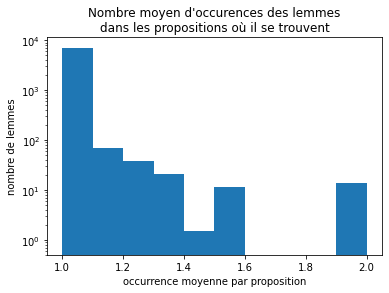

In [19]:
plt.hist(df["Nombre moyen par document"], log = True, bottom = .5)
plt.xlabel("occurrence moyenne par proposition")
plt.ylabel("nombre de lemmes")
_ = plt.title("Nombre moyen d'occurences des lemmes\ndans les propositions où il se trouvent")

In [20]:
df.sort_values(by = ['Nombre moyen par document'], inplace = True, ascending=False)
px.bar(df.iloc[:10,:], x = 'Lemme', y = 'Nombre moyen par document', title = "Nombre moyen d'occurences des lemmes dans les documents où il se trouvent")